In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from myfunctions import set_importer, scores
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV, RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, plot_confusion_matrix, classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
pd.set_option('display.max_columns', None)
from sklearn import tree

sns.set_style("whitegrid")
%matplotlib inline

# setting font size for all plots
font = {'size'   : 16}

plt.rc('font', **font)

In [2]:
# importing the necessary sets
X_train = set_importer('../analysis-dfs/X_train_ordinal_encoded.csv')
X_test = set_importer('../analysis-dfs/X_test_ordinal_encoded.csv')

y_train = set_importer('../analysis-dfs/y_train_prepared_2.csv', y=True)
y_test = set_importer('../analysis-dfs/y_test_prepared.csv', y=True)

display(X_train.shape)
X_train.head(10)

(29852, 16)

,gps_height,longitude,latitude,region_code,district_code,population,permit,construction_year,basin,extraction_type_class,management_group,payment,quality_group,quantity_group,source_class,waterpoint_type_group
0,-0.356274,1.723728,-1.640197,-0.393261,-0.194167,1.366671,0.66262,0.801349,-1.550911,-1.417821,-0.314342,-0.783634,-0.399189,-1.266481,-0.529080,-0.832690
1,-0.884573,-0.348901,-1.036569,-0.240379,0.092932,-0.675954,0.66262,-1.231119,-1.159302,-0.652663,-0.314342,-0.190823,-0.399189,-0.677096,1.788588,-0.832690
2,-0.884573,-0.267184,-1.007222,-0.240379,0.092932,-0.675954,0.66262,-1.231119,-1.159302,-0.652663,-0.314342,-0.783634,-0.399189,-0.087711,1.788588,-0.832690
3,-0.693453,1.097498,-0.507180,-0.597103,-0.385566,1.025095,0.66262,0.816731,-0.767692,0.112494,-0.314342,-0.190823,0.853827,-0.677096,-0.529080,0.319603
4,0.993994,-0.536809,1.177516,0.167305,-0.194167,1.366671,-1.50916,0.828011,-0.376083,0.112494,-0.314342,0.401987,2.106843,0.501674,-0.529080,0.319603
5,0.933395,-0.798928,1.241827,0.116345,-0.481266,2.732976,0.66262,0.815706,-0.376083,0.112494,-0.314342,-0.783634,-0.399189,-0.677096,-0.529080,0.319603
6,-0.884573,-1.349221,1.396173,0.065384,-0.385566,-0.675954,0.66262,-1.231119,-0.376083,0.877651,-0.314342,-0.783634,-0.399189,-0.677096,-0.529080,1.471897
7,-0.884573,-0.072088,1.885445,0.014424,-0.481266,-0.675954,-1.50916,-1.231119,-0.376083,0.877651,1.079108,-0.783634,0.853827,1.091059,-0.529080,1.471897
8,0.736060,0.033395,-1.704817,-0.342300,-0.289867,-0.341209,0.66262,0.809553,-1.550911,-0.652663,-0.314342,0.401987,-0.399189,-1.266481,-0.529080,-0.832690
9,2.404861,-0.405766,-1.092367,-0.291340,-0.289867,-0.675954,-1.50916,0.793146,-1.159302,-0.652663,-0.314342,0.994798,-0.399189,1.091059,-0.529080,-0.832690


## Building Itertative models to find the Best Decision Tree Model

### Decision Tree Classifier with criterion gini

In [3]:
dtc_gini = DecisionTreeClassifier(criterion='gini', random_state=21)

dtc_gini.fit(X_train, y_train)

y_preds_gini = dtc_gini.predict(X_test)
y_probs_gini = dtc_gini.predict_proba(X_test)[:, 1]

In [4]:
print('Model scores with gini criterion')
scores(y_test, y_preds_gini)

Model scores with gini criterion
The precision score is:	 0.8490742910710101
The recall score is:	 0.5603154964429322
The accuracy score is:	 0.542748492001049
The f1 score is:	 0.6751141339793161


### Decision Tree Classifier with criterion entropy

In [5]:
dtc_entropy = DecisionTreeClassifier(criterion='entropy', random_state=21)

dtc_entropy.fit(X_train, y_train)

y_preds_entropy = dtc_entropy.predict(X_test)

In [6]:
print('Model scores with gini criterion')
scores(y_test, y_preds_entropy)

Model scores with gini criterion
The precision score is:	 0.8559880239520958
The recall score is:	 0.44215898546241883
The accuracy score is:	 0.46393915552058745
The f1 score is:	 0.5831123801754028


Both models did not do well compared to the best model in logistic regression part. Maybe tunning will help. 
I will continue with the gini criterion since it scored the highest recall score, and in our case we are intersted in locating as many fixable water pumps as possibel. Recall because we are False Negatives are a bigger problem.

#### min_samples_split

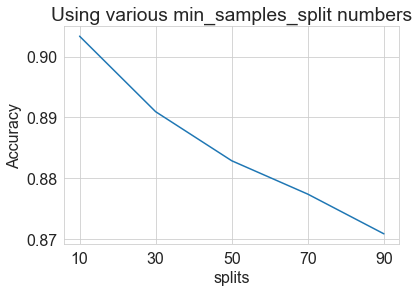

In [7]:
splits = np.arange(10, 100, 20)
accuracy_means = []

for split in splits:
    dtc_model = DecisionTreeClassifier(criterion='gini', random_state=21, min_samples_split=split)
    accuracy_means.append( cross_val_score(dtc_model, X_train, y_train, scoring='accuracy').mean() )

plt.plot(splits, accuracy_means)
plt.xlabel('splits')
plt.xticks(splits)
plt.ylabel('Accuracy')
plt.title('Using various min_samples_split numbers')
plt.show() 

An increase in the number of min sample splits results in detoriating the model hence will stick with the default model

#### min_samples_leaf

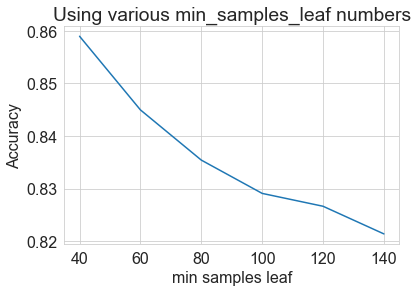

In [8]:
samples = np.arange(40,160,20)
accuracy_means = []

for sample in samples:
    dtc_model = DecisionTreeClassifier(criterion='gini', random_state=21,  min_samples_leaf=sample)
    accuracy_means.append( cross_val_score(dtc_model, X_train, y_train, scoring='accuracy').mean() )

plt.plot(samples, accuracy_means)
plt.xlabel('min samples leaf')
plt.xticks(samples)
plt.ylabel('Accuracy')
plt.title('Using various min_samples_leaf numbers')
plt.show() 

An increase in the number of min sample leafs results in detoriating the model hence will stick with the default model

#### max_depth

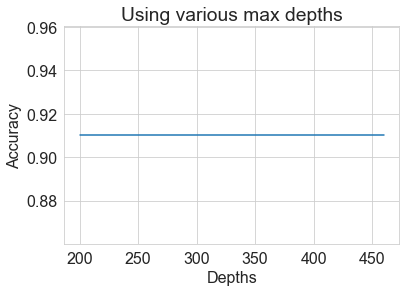

In [9]:
depths = np.arange(200,470,20)
accuracy_means = []

for depth in depths:
    dtc_model = DecisionTreeClassifier(criterion='gini', random_state=21, max_depth=depth)
    accuracy_means.append( cross_val_score(dtc_model, X_train, y_train, scoring='accuracy').mean() )

plt.plot(depths, accuracy_means)
plt.xlabel('Depths')
plt.ylabel('Accuracy')
plt.title('Using various max depths')
plt.show()

Max depth has no effect.

#### max_features

/home/iain/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/iain/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/iain/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/home/iain/.local/lib/python3.8/site-packages/sklearn/tree/_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.wa

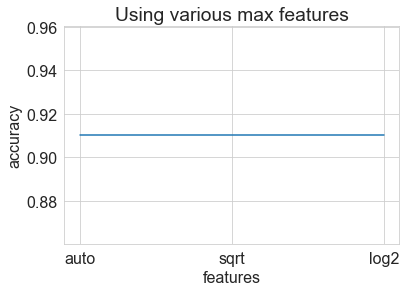

In [23]:
features = ['auto', 'sqrt', 'log2']
accuracy_means = []

for feature in features:
    dtc_model = DecisionTreeClassifier(criterion='gini', random_state=21, max_features=feature)
    accuracy_means.append( cross_val_score(dtc_model, X_train, y_train, scoring='accuracy').mean() )

plt.plot(features, accuracy_means)
plt.xlabel('features')
plt.ylabel('accuracy')
plt.xticks(features)
plt.title('Using various max features')
plt.show()

No effect was notice hence will stick with these parameters: criterion='gini', random_state=21, min_samples_split=460, min_samples_leaf=70.

## The best model

In [11]:
best_dtr_model = DecisionTreeClassifier(criterion='gini', random_state=21)
best_dtr_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=21)

In [12]:
y_preds_best = best_dtr_model.predict(X_test)
print('Decision Tree Classifier best model results on the testing set.')
scores(y_test, y_preds_best)

Decision Tree Classifier best model results on the testing set.
The precision score is:	 0.8490742910710101
The recall score is:	 0.5603154964429322
The accuracy score is:	 0.542748492001049
The f1 score is:	 0.6751141339793161


/home/iain/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


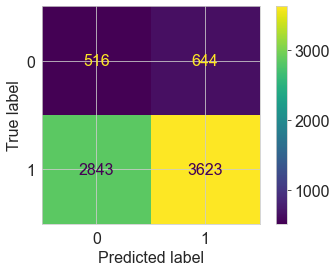

In [13]:
# confusion matrix
plot_confusion_matrix(best_dtr_model, X_test, y_test)
plt.show()

This model clearly perfomrs worse than the best logistic regression model. Maybe feature selection will help

## Feature Selection

Using RFECV which perform RFE in a cross-validation loop to find the best features.

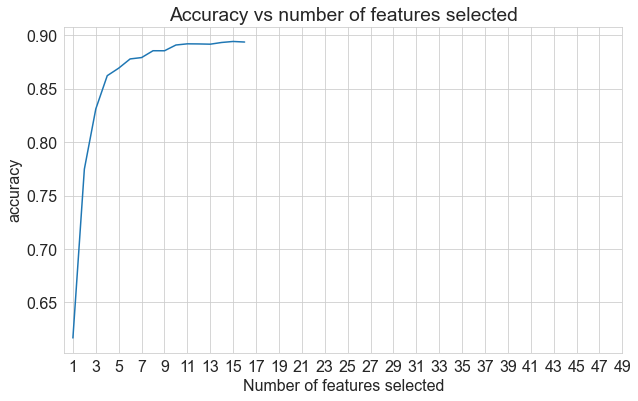

In [14]:
rfecv = RFECV(best_dtr_model, scoring='accuracy', cv=2)
rfecv.fit(X_train, y_train)
# plotting the results
plt.figure(figsize=(10,6))
plt.plot(np.arange(1, len(rfecv.cv_results_['mean_test_score'])+1), rfecv.cv_results_['mean_test_score'])
plt.ylabel('accuracy')
plt.xlabel('Number of features selected')
plt.xticks(np.arange(1, 51, 2))
plt.title('Accuracy vs number of features selected')
plt.show()

According to rfecv 16 number of features produced the best accuracy score

In [15]:
columns_to_select = X_train.columns[rfecv.support_]

In [16]:
list(columns_to_select)

['gps_height',
 'longitude',
 'latitude',
 'region_code',
 'district_code',
 'population',
 'permit',
 'construction_year',
 'basin',
 'extraction_type_class',
 'payment',
 'quality_group',
 'quantity_group',
 'source_class',
 'waterpoint_type_group']

Investing other scores selecting the best features selected using RFECV

In [17]:
best_dtr_model = DecisionTreeClassifier(criterion='gini', random_state=21)
best_dtr_model.fit(X_train[columns_to_select], y_train)

DecisionTreeClassifier(random_state=21)

In [18]:
y_preds_best = best_dtr_model.predict(X_test[columns_to_select])
print('Decision Tree Classifier best model results on the testing set.')
scores(y_test, y_preds_best)

Decision Tree Classifier best model results on the testing set.
The precision score is:	 0.8424359594006766
The recall score is:	 0.5391277451283637
The accuracy score is:	 0.5237345921846315
The f1 score is:	 0.6574877404752923


/home/iain/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


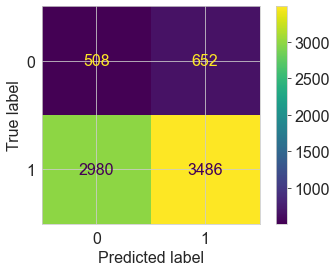

In [19]:
# confusion matrix
plot_confusion_matrix(best_dtr_model, X_test[columns_to_select], y_test)
plt.show()

## Bagged Tree Classifier

Before intializing a bagging classifier model I will first start with finding the best number of estimators.

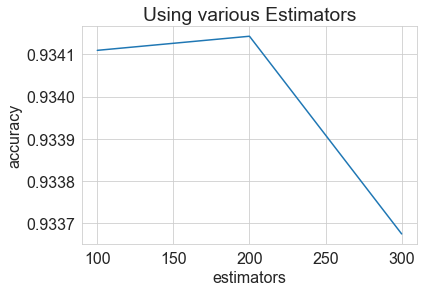

In [22]:
estimators = [100,200,300]
log_loss_means = []

for estimator in estimators:
    btc_model = BaggingClassifier(DecisionTreeClassifier(criterion='gini', random_state=21), n_estimators=estimator)
    log_loss_means.append( cross_val_score(btc_model, X_train[columns_to_select], y_train, scoring='accuracy').mean() )

plt.plot(estimators, log_loss_means)
plt.xlabel('estimators')
plt.ylabel('accuracy')
plt.title('Using various Estimators')
plt.show()

n_estimators = 200 produced a higher accuracy score

#### Creating a baggingClassifier

In [ ]:
bagging_classifier = BaggingClassifier(DecisionTreeClassifier(criterion='gini', random_state=21), n_estimators=200)
bagging_classifier.fit(X_train[columns_to_select], y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=21),
                  n_estimators=200)

In [ ]:
y_test_bag = bagging_classifier.predict(X_test[columns_to_select])
print('Decision Tree Classifier best model results on the test set')
scores(y_test, y_test_bag)

Decision Tree Classifier best model results on the test set
The precision score is:	 0.8538024015167475
The recall score is:	 0.6268171976492422
The accuracy score is:	 0.592578022554419
The f1 score is:	 0.7229109069829662


/home/iain/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


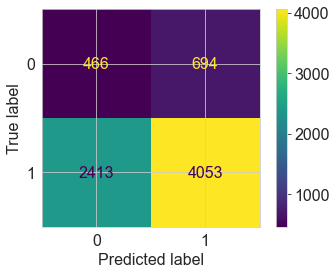

In [22]:
# confusion matrix
plot_confusion_matrix(bagging_classifier, X_test[columns_to_select], y_test)
plt.show()

Even tho a lesser log loss was recognized here the accuracy score plus the recall score were really low. Maybe another ensemble method will produce better results

## Random forest Classifier

Before intializing a Random forest classifier model I will first start with finding the best number of estimators. Using the same parameters as the one obtained in the best decision tree regression model.

In [23]:
grid_params = {
    'min_samples_split': [100, 200, 460],
    'min_samples_leaf': [70],
    'n_estimators': [10,100,200,300]
}


In [24]:
rfc = RandomForestClassifier()
grid_search = GridSearchCV(rfc, grid_params, cv=4)
grid_search.fit(X_train[columns_to_select], y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': [70],
                         'min_samples_split': [100, 200, 460],
                         'n_estimators': [10, 100, 200, 300]})

In [25]:
grid_search.best_params_

{'min_samples_leaf': 70, 'min_samples_split': 100, 'n_estimators': 300}

The best parameter for the RandomForestClassifier are {'criterion': 'entropy', 'min_samples_split':100, 'n_estimators': 200}

In [31]:
rf_classifier = RandomForestClassifier(criterion='gini', random_state=21, min_samples_split=70, min_samples_leaf=100, n_estimators=300)
rf_classifier.fit(X_train[columns_to_select], y_train)

RandomForestClassifier(min_samples_leaf=100, min_samples_split=70,
                       n_estimators=300, random_state=21)

In [32]:
y_test_rf_preds = rf_classifier.predict(X_test[columns_to_select])
print('RandomForest Classifier best model results on the training set')
scores(y_test, y_test_rf_preds)

RandomForest Classifier best model results on the training set
The precision score is:	 0.8798436991208075
The recall score is:	 0.8357562635323229
The accuracy score is:	 0.7639653815892997
The f1 score is:	 0.857233502538071


/home/iain/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


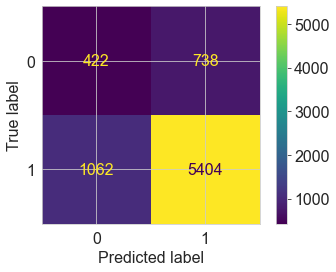

In [33]:
# confusion matrix
plot_confusion_matrix(rf_classifier, X_test[columns_to_select], y_test)
plt.show()

In [34]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_rf_preds))

              precision    recall  f1-score   support

           0       0.28      0.36      0.32      1160
           1       0.88      0.84      0.86      6466

    accuracy                           0.76      7626
   macro avg       0.58      0.60      0.59      7626
weighted avg       0.79      0.76      0.78      7626



In [35]:
y_test.value_counts()

1    6466
0    1160
Name: 0, dtype: int64

In [36]:
pd.Series(y_test_rf_preds).value_counts()

1    6142
0    1484
dtype: int64

### Interpretating the final model

**Interpreting the model**
* Precision-Score - If the model assigns 1 then there is a 88.8% chance that a water pump is actually non functional. 
* Recal-Score - If a given water pump is actually 1 (non-functional) then there is a 53.9% that this model will label it as 1 (non-functional), and a 46.1 chance that it will incorrectly label it as 0 (functional but need repair). This is poor compared to the logistic regression model.
* Accuracy-Score - The model accrately assigns 55.1% to the correct label. 


This model scored a better recall score compared to the logistic regression model and knn model hence qualifies to be the best model.

## This is the best model